In [14]:
import yaml
import inspect
import napari_workflows as nw
from napari.types import ImageData
from napari_segment_blobs_and_things_with_membranes import gaussian_blur
from skimage.io import imread


w = nw.Workflow()
w.set('denoised',gaussian_blur,'input', sigma = 5)
w.set('input',imread("C:/Users/ryans/Desktop/blobs.tif"))

function = w._tasks['denoised'][0]    
args = [None] + list(w._tasks['denoised'][2:])

sig = inspect.signature(function)
sig

<Signature (image: napari.types.ImageData, sigma: float = 1, viewer: napari.viewer.Viewer = None) -> napari.types.ImageData>

In [9]:
kwargs = {'sigma':4}
bound = sig.bind_partial(**kwargs)
bound

<BoundArguments (sigma=4)>

In [21]:
from inspect import Signature, signature
from functools import partial

def signature_w_kwargs_from_function(function, arg_vals: list) -> Signature:
    
    # getting the keywords corresponding to the values
    keyword_list = list(signature(function).parameters.keys())

    # creating the kwargs dict
    kw_dict = {}
    for kw, val in zip(keyword_list, arg_vals):
        kw_dict[kw] = val
    kw_dict.pop('image') # we are making an assumption that the input will aways be this
    
    sig = signature(partial(function, **kw_dict))
    
    return sig
func = w._tasks['denoised'][0]
sig2 = signature_w_kwargs_from_function(func,w._tasks['denoised'][1:])
sig2

<Signature (image: napari.types.ImageData, *, sigma: float = 5, viewer: napari.viewer.Viewer = None) -> napari.types.ImageData>

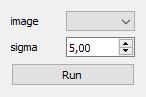

In [23]:
import magicgui

func.__signature__ = sig2
signature(func)
magicgui.magicgui(func)